# Fit Keypoint MoSeq Model to DLC data

We will first import the libraries needed. If you get an error, check that you're running the notebook inside the environment where DeepLabCut is installed.

In [22]:
import keypoint_moseq as kpms
import os
import numpy as np
from jax_moseq.utils import set_mixed_map_iters
set_mixed_map_iters(4)

Below we specify the data folder for the project. We need a DLC folder as well.

In [31]:
project_dir = 'S:\\ElboustaniLab\\#SHARE\\Analysis\\KeypointMoSeq\\MoSeq_Training'
dlc_dir     = 'S:\\ElboustaniLab\\#SHARE\\Analysis\\JointDecisionDeepLabCut\\NeuroPixelsBox-DK-2023-08-14'
dlc_config  = os.path.join(dlc_dir,'config.yaml')

config = lambda: kpms.load_config(project_dir)
kpms.setup_project(project_dir, deeplabcut_config=dlc_config,overwrite=True)

In [32]:
kpms.update_config(
    project_dir,
    video_dir=project_dir,
    conf_threshold=0.9,
    anterior_bodyparts=['shoulder'],
    posterior_bodyparts=['tailbase'],
    use_bodyparts=[
        'tailbase', 'spine4', 'spine3', 'spine2', 'spine1',
        'shoulder', 'snout', 'rightear', 'leftear'])

In [34]:
coordinates, confidences, bodyparts = kpms.load_keypoints(os.path.join(project_dir, 'data_fit'), 'deeplabcut')
# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config())

Loading keypoints: 100%|████████████████| 11/11 [00:57<00:00,  5.22s/it]


>=90.0% of variance exlained by 4 components.


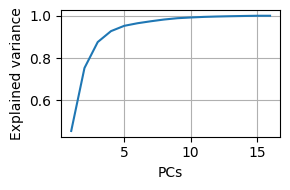

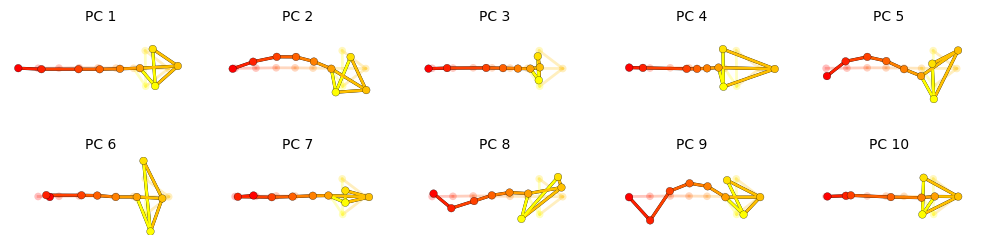

In [35]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())


## Initialize with AR model (kappa selection important)

In [36]:
model = kpms.init_model(data, pca=pca, **config())

Outputs will be saved to S:\ElboustaniLab\#SHARE\Analysis\KeypointMoSe
q\MoSeq_Training\2024_07_05-14_14_10


 49%|█████████████████▏                 | 25/51 [10:58<11:28, 26.48s/it]

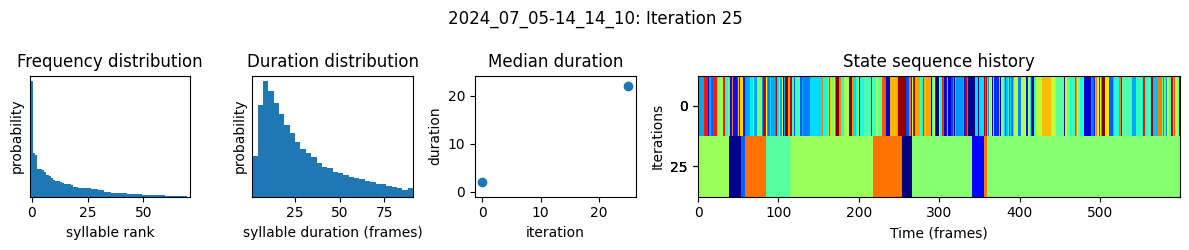

 98%|██████████████████████████████████▎| 50/51 [22:12<00:26, 26.50s/it]

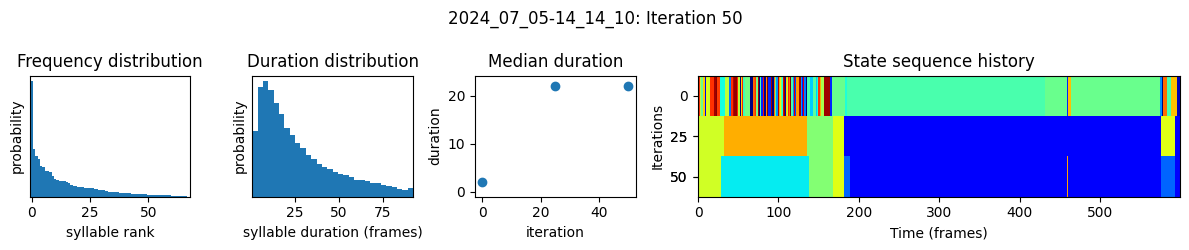

100%|███████████████████████████████████| 51/51 [22:57<00:00, 27.00s/it]

2024_07_05-14_14_10


In [37]:
num_ar_iters = 50
model = kpms.update_hypparams(model, kappa=1e12)
model, model_name = kpms.fit_model(model, data, metadata, project_dir,
    ar_only=True, num_iters=num_ar_iters)

print(model_name)

## Fit full MoSeq model

Outputs will be saved to S:\ElboustaniLab\#SHARE\Analysis\KeypointMoSe
q\MoSeq_Training\2024_07_05-14_14_10


  5%|█▍                          | 25/501 [1:00:19<18:39:02, 141.05s/it]

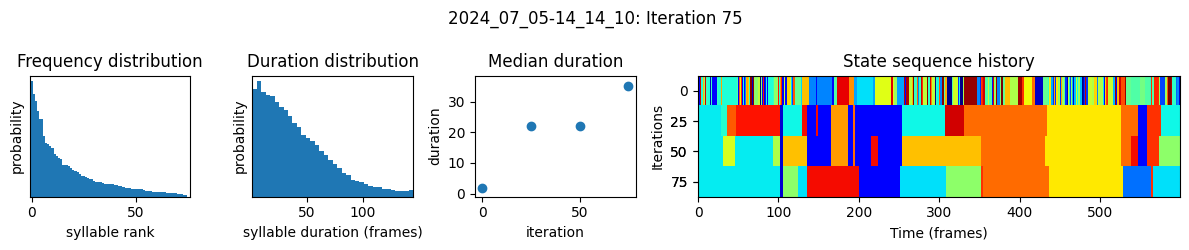

 10%|██▊                         | 50/501 [1:59:14<17:35:17, 140.39s/it]

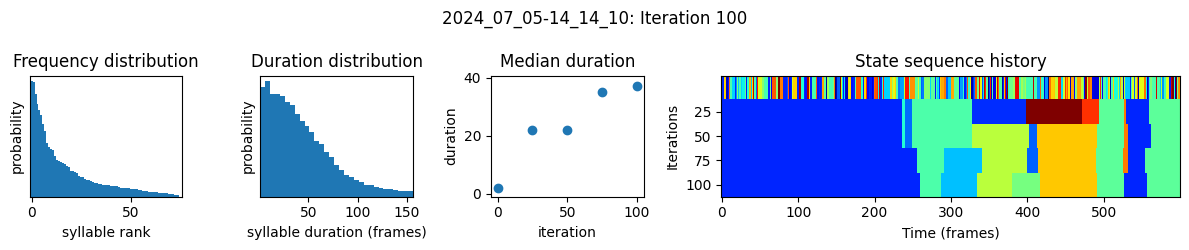

 15%|████▏                       | 75/501 [2:59:10<16:37:06, 140.44s/it]

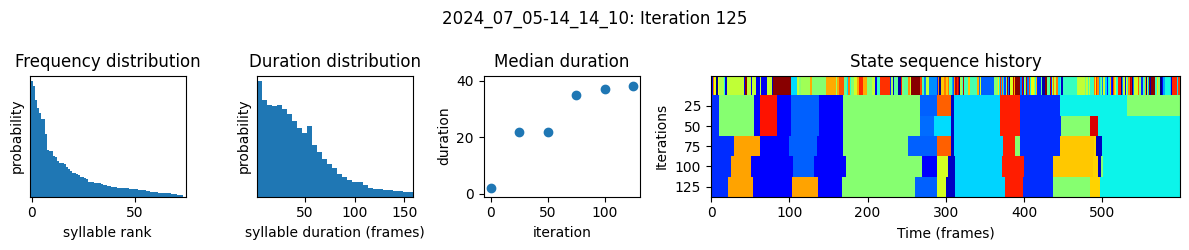

 20%|█████▍                     | 100/501 [3:58:07<15:40:24, 140.71s/it]

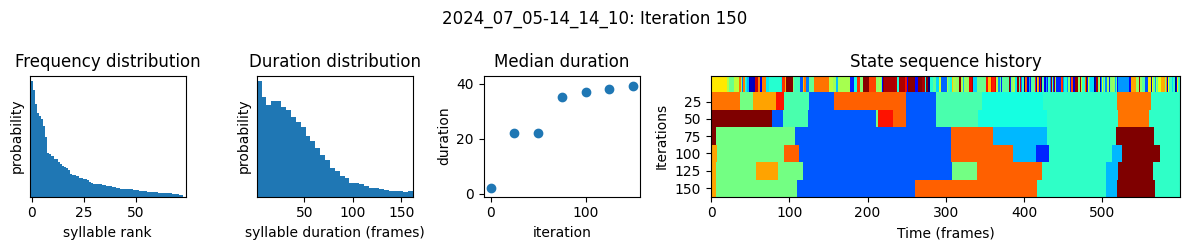

 25%|██████▋                    | 125/501 [4:56:55<14:38:57, 140.26s/it]

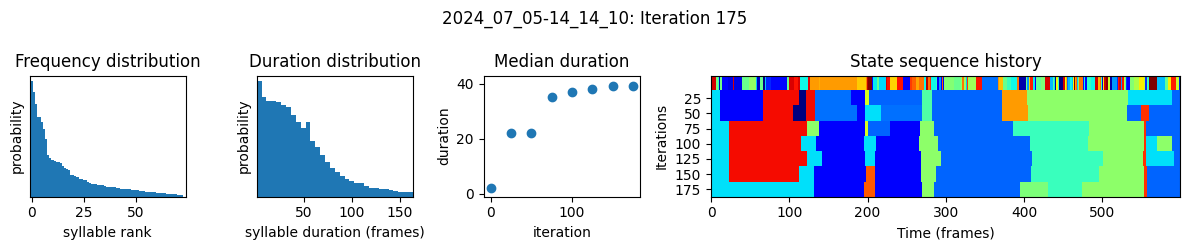

 30%|████████                   | 150/501 [5:55:39<13:41:23, 140.41s/it]

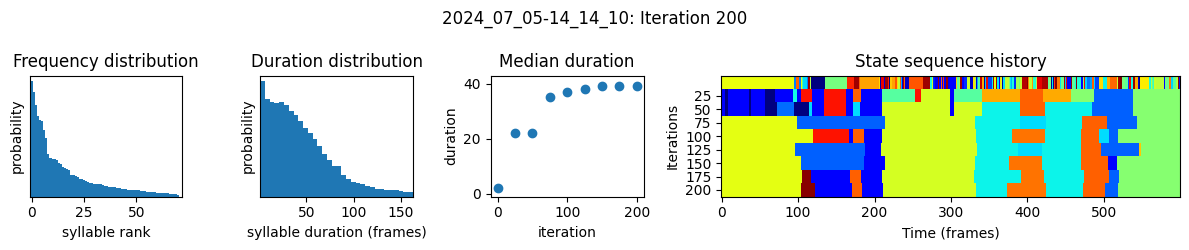

 35%|█████████▍                 | 175/501 [6:54:29<12:41:06, 140.08s/it]

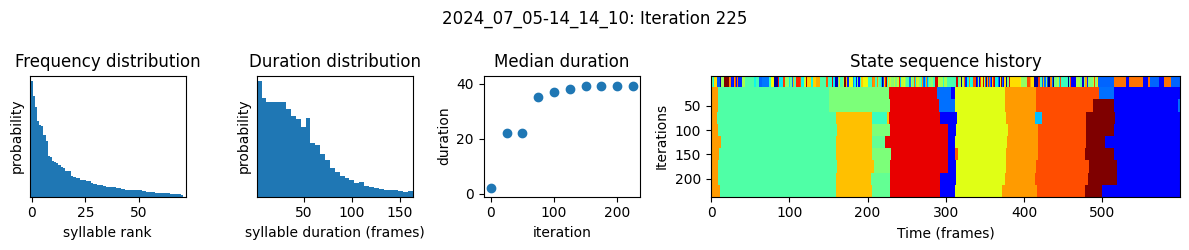

 40%|██████████▊                | 200/501 [7:53:18<11:42:55, 140.12s/it]

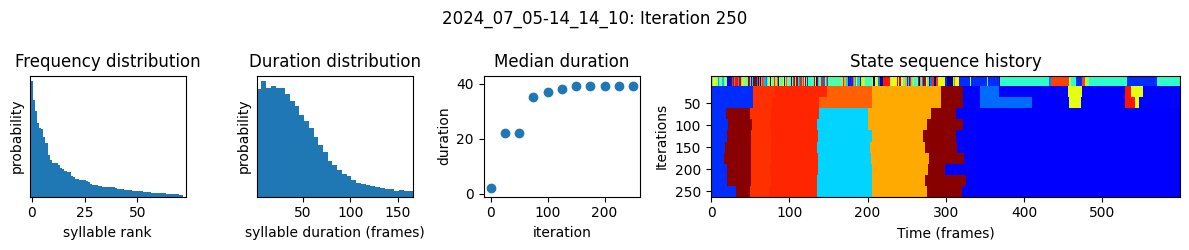

 45%|████████████▏              | 225/501 [8:52:09<10:46:33, 140.56s/it]

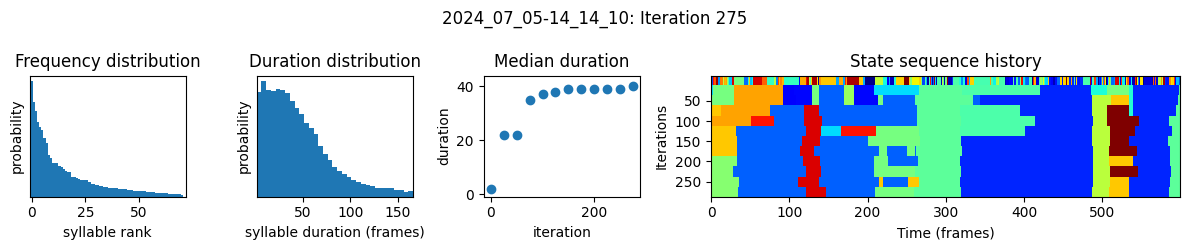

 50%|█████████████▉              | 250/501 [9:51:01<9:47:16, 140.39s/it]

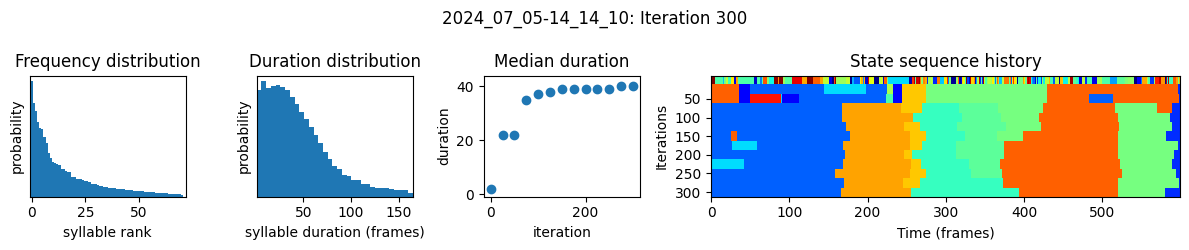

 55%|██████████████▊            | 275/501 [10:49:56<8:47:15, 139.98s/it]

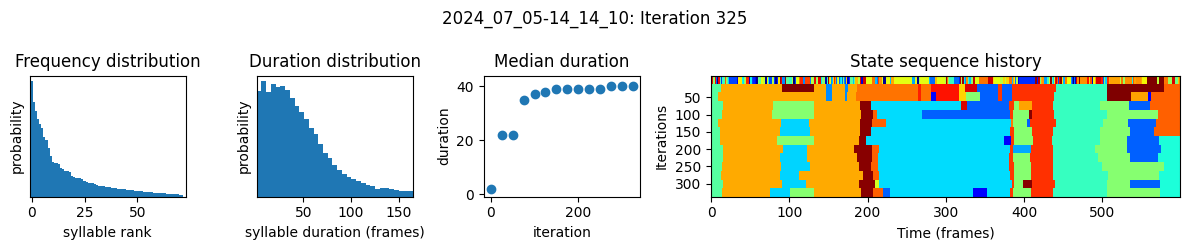

 60%|████████████████▏          | 300/501 [11:48:46<7:49:28, 140.14s/it]

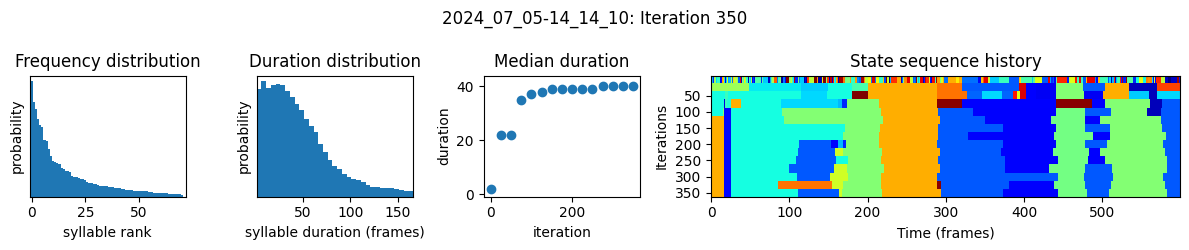

 65%|█████████████████▌         | 325/501 [12:47:50<6:51:19, 140.23s/it]

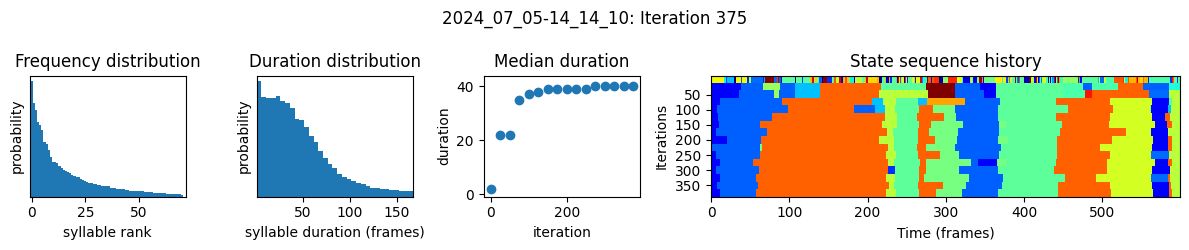

 70%|██████████████████▊        | 350/501 [13:46:52<5:53:46, 140.58s/it]

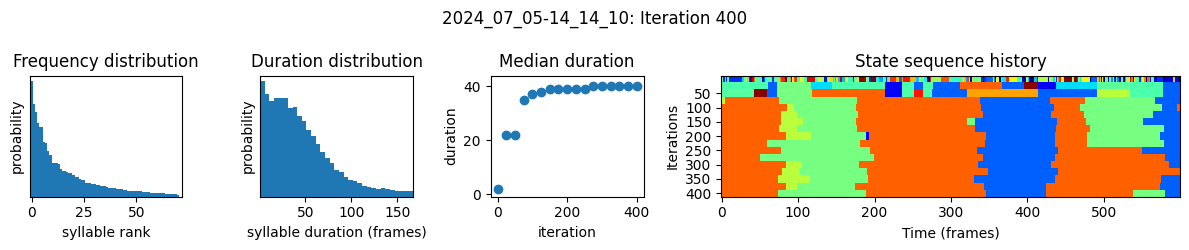

 75%|████████████████████▏      | 375/501 [14:46:13<4:55:07, 140.53s/it]

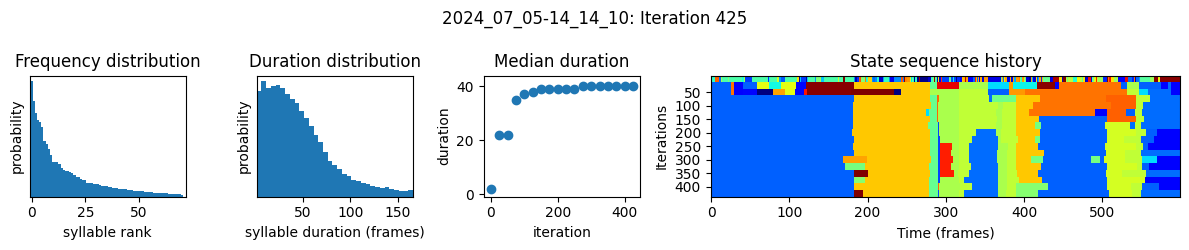

 80%|█████████████████████▌     | 400/501 [15:45:10<3:56:25, 140.45s/it]

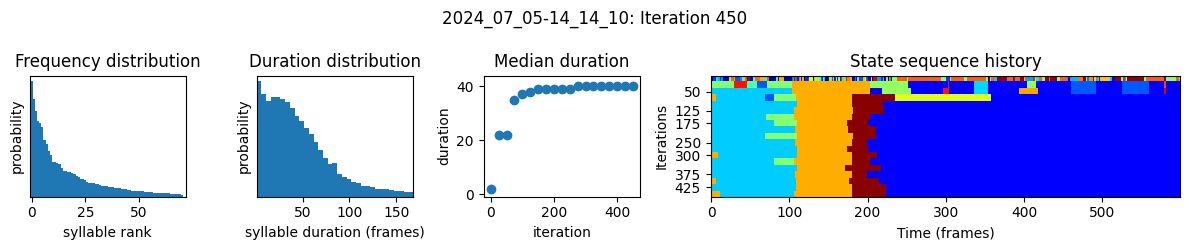

 85%|██████████████████████▉    | 425/501 [16:44:03<2:57:27, 140.10s/it]

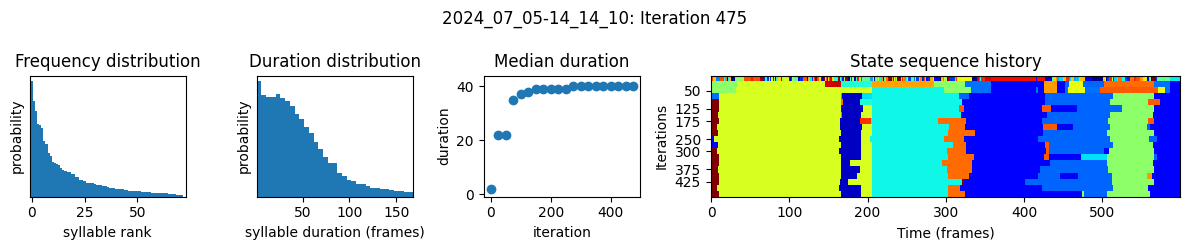

 90%|████████████████████████▎  | 450/501 [17:42:57<1:59:21, 140.43s/it]

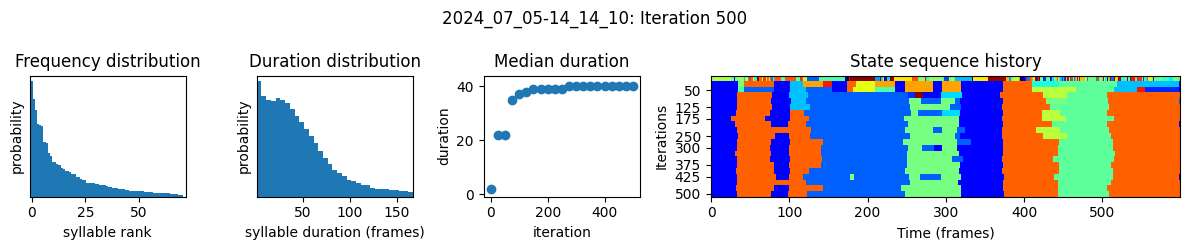

 95%|█████████████████████████▌ | 475/501 [18:41:53<1:00:48, 140.34s/it]

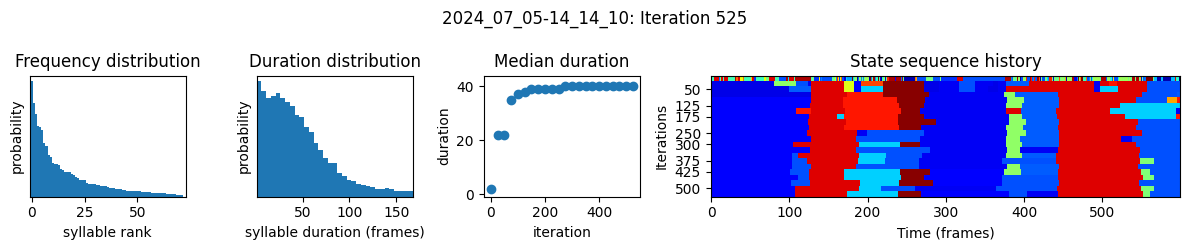

100%|████████████████████████████▉| 500/501 [19:40:53<02:20, 140.45s/it]

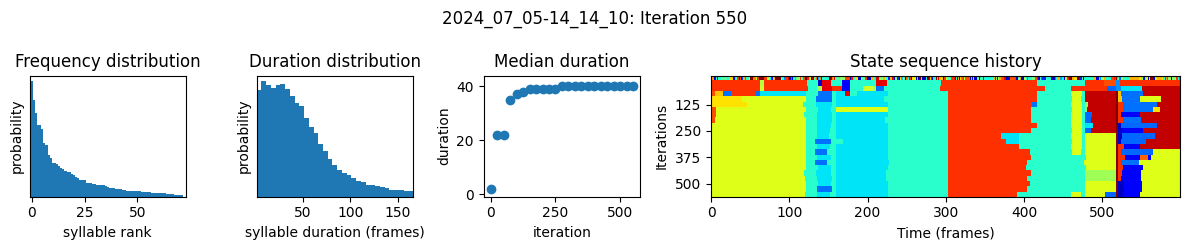

100%|█████████████████████████████| 501/501 [19:43:38<00:00, 141.75s/it]


In [38]:
# load model checkpoint
num_ar_iters = 50
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e6)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name, ar_only=False, 
    start_iter=current_iter, num_iters=current_iter+500, parallel_message_passing=False)[0]
    

Saved results to S:\ElboustaniLab\#SHARE\Analysis\KeypointMoSeq\MoSeq_
Training\2024_07_05-14_14_10\results.h5
Saving trajectory plots to S:\ElboustaniLab\#SHARE\Analysis\KeypointMoSeq\MoSeq_Training\2024_07_05-14_14_10\trajectory_plots


Generating trajectory plots: 100%|██████| 41/41 [00:16<00:00,  2.54it/s]


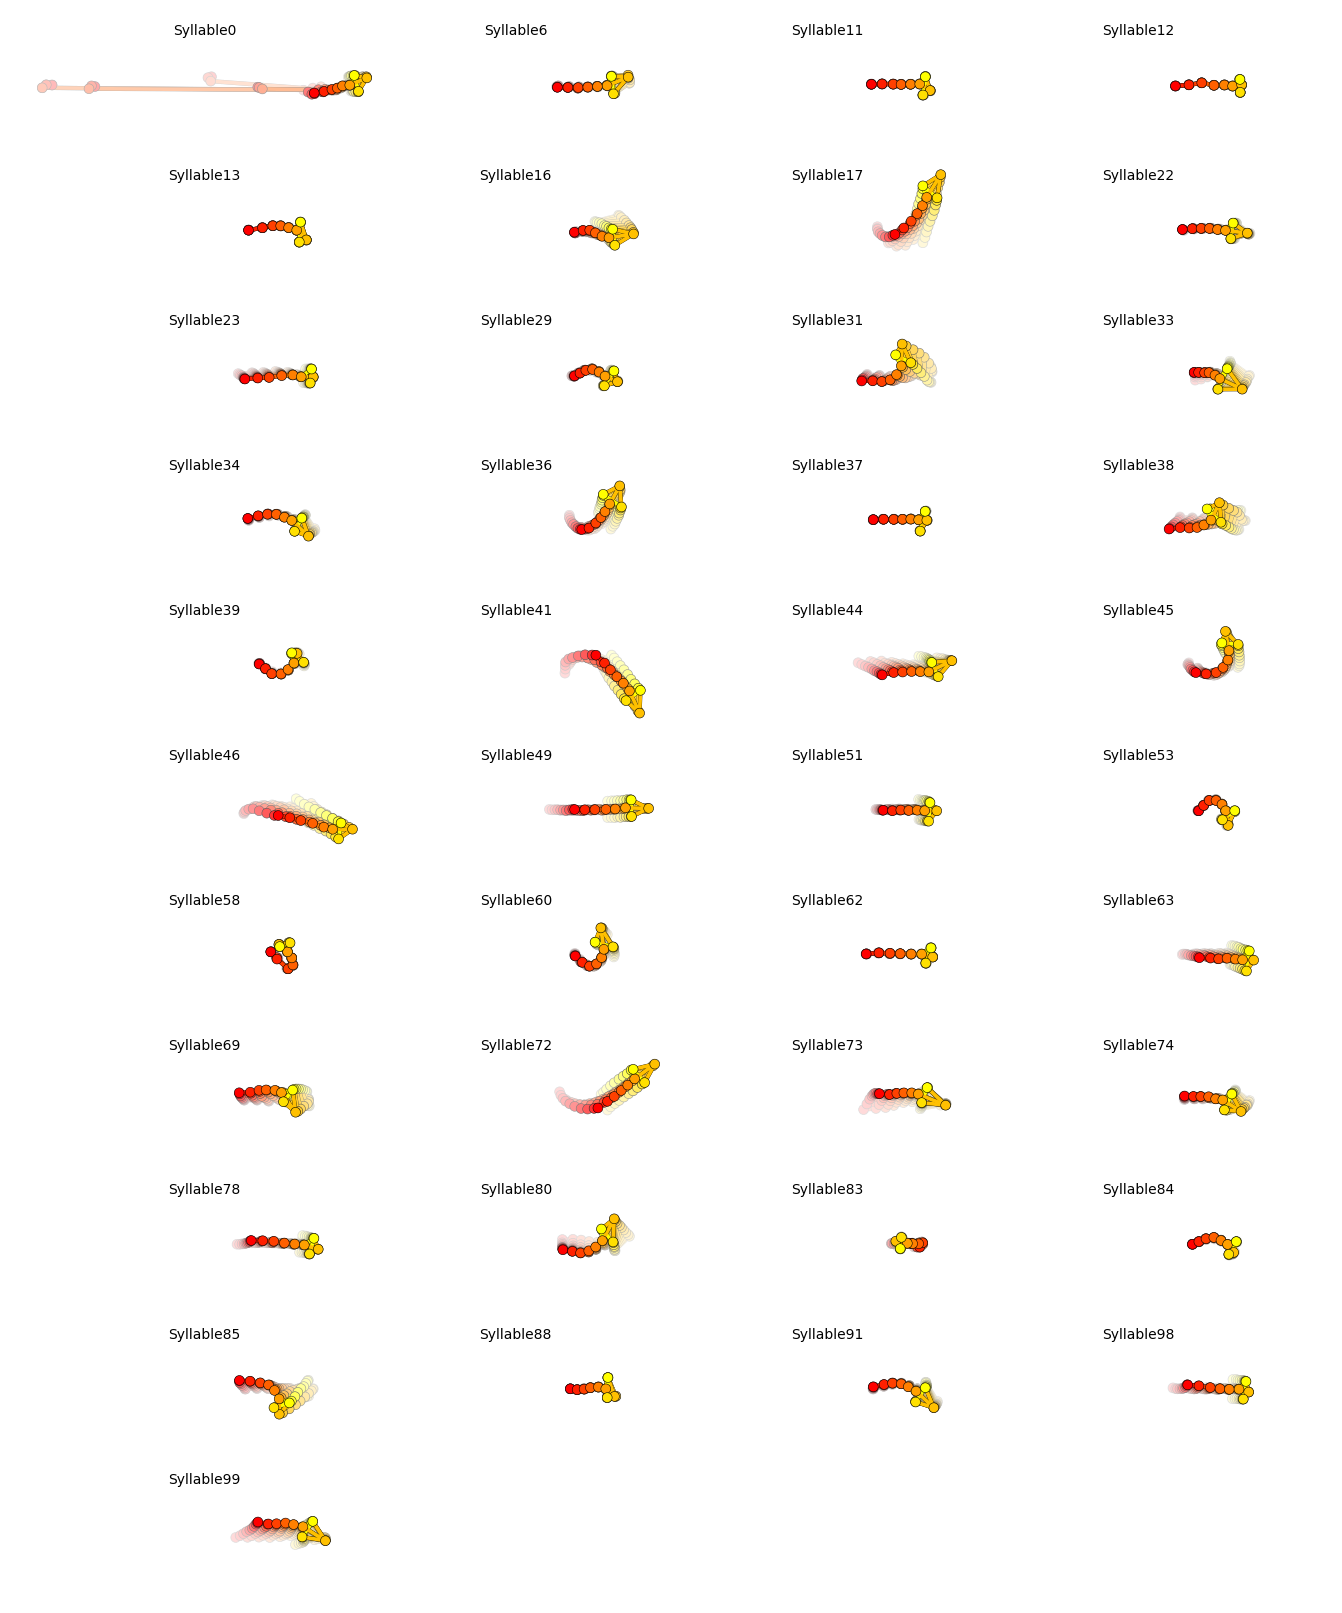

Saving to csv: 100%|████████████████████| 11/11 [02:02<00:00, 11.15s/it]


In [39]:
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters)

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name)

kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, **config())

# optionally save results as csv
kpms.save_results_as_csv(results, project_dir, model_name)

Saving dendrogram plot to S:\ElboustaniLab\#SHARE\Analysis\KeypointMoSeq\MoSeq_Training\2024_07_05-14_14_10\similarity_dendrogram


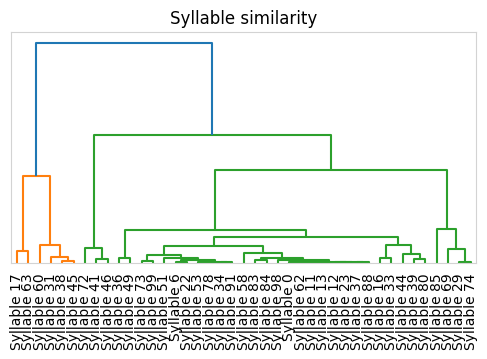

In [40]:
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, **config())